<a href="https://colab.research.google.com/github/ernstmargo/anomaly-detection/blob/main/Kmean_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and read data

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import ipaddress 
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=2d23c71b0f6409dfb73c4d9c32d21ad5126bc12bd2fb81a98771409d12f43bcc
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/full_dataset')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_w=pd.read_csv('/content/drive/MyDrive/Dataset/Wednesday-workingHours.pcap_ISCX.csv')


#Preprocessing 





In [5]:
def format_name(columns):
  col= []
  for x in columns:
        x=x.strip().lower().replace(' ', '_').replace('/', '_').replace('.', '_')
        col.append(x)
  return col
  
def ip_to_int(ip):
   new_ip=int(ipaddress.ip_address(ip))
   return new_ip

def rename_lables(df):
    df=df.replace({'label': {'DoS slowloris':'DOS','DoS Slowhttptest':'DOS', 'DoS Hulk':'DOS', 'DoS GoldenEye':'DOS', 'Heartbleed':'DOS', 'DDOS':'DOS'}})
    df.loc[ df['label'] !='DOS', 'label'] = 'BENIGN'
    df=df.replace({'label': {'BENIGN':0, 'DOS':1}})
    label_unique=df['label'].unique()
    k=0
    for x in label_unique:
        df=df.replace({'label': {x:k}})
        k=k+1
    return df

def preprocessing(df):
  df.columns=format_name(df.columns)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['timestamp'] = df['timestamp'].values.astype('float')
  df['source_ip']=df['source_ip'].apply(ip_to_int)
  df['destination_ip']=df['destination_ip'].apply(ip_to_int)
  df=df.drop(columns=['flow_id'])
  df=rename_lables(df)
  y=df['label'].astype(int)
  x=df.drop(columns=['label'])
  return df, x, y
  


In [9]:
df_preproc, x, y=preprocessing(df_w)
# here df or df_w is chosen and determens if the test run is for Full or Wednesday dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42, shuffle=False)
#train/test split for feature selection 

In [11]:
y_inv=np.logical_not(y).astype(int) 

#Scale

In [12]:
from sklearn.preprocessing import scale
from sklearn import preprocessing


In [13]:
x_scaled=scale(x)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
x_min_max=min_max_scaler.fit_transform(x)
x_train_min_max=min_max_scaler.fit_transform(x_train)

In [15]:
max_abs_scaler=preprocessing.MaxAbsScaler()
x_max_abs=max_abs_scaler.fit_transform(x)

#Fearture Selection

### Select best 

In [16]:
from sklearn.feature_selection import SelectKBest, chi2

In [17]:
selectkbest_chi = SelectKBest(chi2, k=20).fit(x_train_min_max, y_train)
x_min_max_selectkbest_chi = selectkbest_chi.transform(x_min_max)

In [18]:
col_index=selectkbest_chi.get_support()

###PCA

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_min_max)


In [21]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [23]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.shape

(692703, 3)

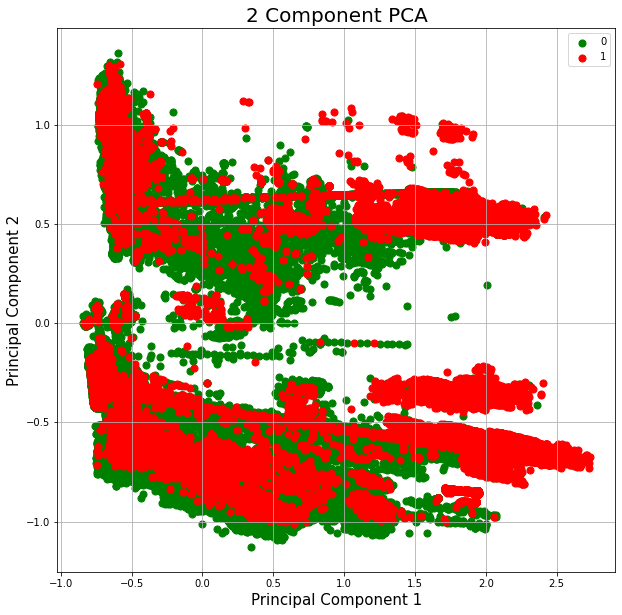

In [24]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('6class.png')

#K means


In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support,precision_score, recall_score, f1_score, classification_report


In [26]:
def class_Kmean(x, y):
    kmeans = KMeans(n_clusters = 2, random_state=0, algorithm='full').fit(x)
    y_pred= kmeans.predict(x) 
    print(classification_report(y, y_pred, digits=4))
    return y_pred

##Try with diffrent scaling & and feature selection


In [27]:
%load_ext memory_profiler

In [28]:
%%time
%memit
 
predict_scaled=class_Kmean(x_scaled,y)

peak memory: 13329.14 MiB, increment: 4.91 MiB
              precision    recall  f1-score   support

           0     0.8078    0.9658    0.8798    439683
           1     0.9093    0.5985    0.7219    251723

    accuracy                         0.8321    691406
   macro avg     0.8586    0.7822    0.8008    691406
weighted avg     0.8448    0.8321    0.8223    691406

CPU times: user 1min 24s, sys: 31 s, total: 1min 55s
Wall time: 5.73 s


In [29]:
%%time
%memit
predict_min_max=class_Kmean(x_min_max,y)

peak memory: 13342.63 MiB, increment: -0.58 MiB
              precision    recall  f1-score   support

           0     0.8001    0.9615    0.8734    439683
           1     0.8962    0.5805    0.7046    251723

    accuracy                         0.8228    691406
   macro avg     0.8482    0.7710    0.7890    691406
weighted avg     0.8351    0.8228    0.8120    691406

CPU times: user 1min 4s, sys: 30.4 s, total: 1min 34s
Wall time: 5.04 s


In [30]:
%%time
%memit
predict_max_abs_scaler=class_Kmean(x_max_abs, y_inv)

peak memory: 13342.63 MiB, increment: -0.58 MiB
              precision    recall  f1-score   support

           0     0.2025    0.4263    0.2746    251723
           1     0.1051    0.0386    0.0565    439683

    accuracy                         0.1798    691406
   macro avg     0.1538    0.2325    0.1655    691406
weighted avg     0.1406    0.1798    0.1359    691406

CPU times: user 1min 4s, sys: 30.7 s, total: 1min 35s
Wall time: 5.1 s


In [31]:
from sklearn.metrics import confusion_matrix


In [32]:
cf_matrix=confusion_matrix(y, predict_scaled)
cf_matrix


array([[424663,  15020],
       [101056, 150667]])

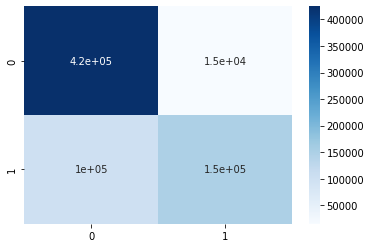

In [33]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')


In [34]:
%%time
%memit
predict_min_max_selectkbest_chi=class_Kmean(x_min_max_selectkbest_chi, y)

peak memory: 13343.55 MiB, increment: -0.52 MiB
              precision    recall  f1-score   support

           0     0.7995    0.9575    0.8714    439683
           1     0.8865    0.5806    0.7016    251723

    accuracy                         0.8202    691406
   macro avg     0.8430    0.7690    0.7865    691406
weighted avg     0.8312    0.8202    0.8096    691406

CPU times: user 44.4 s, sys: 33.2 s, total: 1min 17s
Wall time: 3.96 s


In [35]:
cf_matrix=confusion_matrix(y, predict_min_max_selectkbest_chi)
cf_matrix


array([[420978,  18705],
       [105582, 146141]])

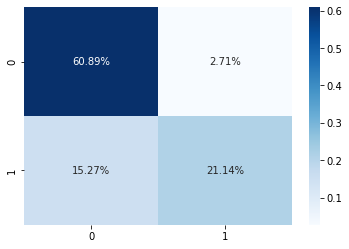

In [36]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [37]:
%%time
%memit
predict_min_max_pca2=class_Kmean(principalComponents, y)

peak memory: 13344.14 MiB, increment: -0.58 MiB
              precision    recall  f1-score   support

           0     0.8001    0.9612    0.8733    439683
           1     0.8954    0.5806    0.7044    251723

    accuracy                         0.8226    691406
   macro avg     0.8478    0.7709    0.7889    691406
weighted avg     0.8348    0.8226    0.8118    691406

CPU times: user 1min 36s, sys: 33.2 s, total: 2min 10s
Wall time: 5.28 s


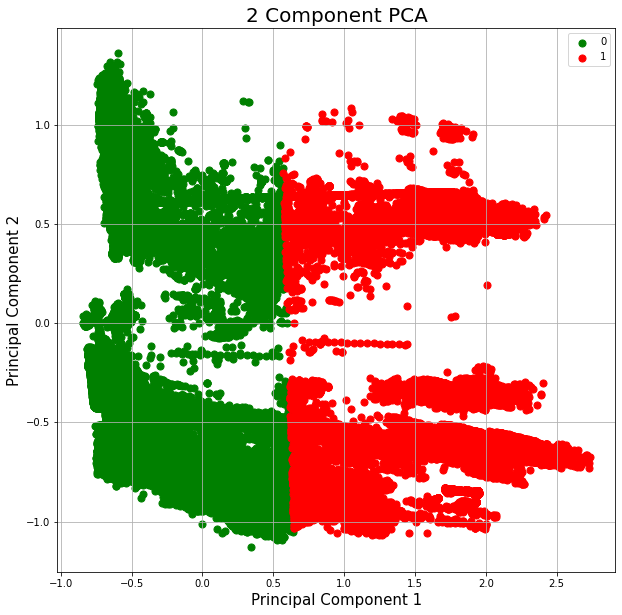

In [38]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors =  ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = predict_min_max_pca2 == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']              
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()